In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import random
random.seed(100)
emoData_365 = []
for i in range(365):
    y = (5/365)*i + random.random()
    emoData_365.append(y)
emoData_365 = np.array(emoData_365)[:,None]
# print(bioData_365)
# print(len(bioData_365))

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
emoData_365 = scaler.fit_transform(emoData_365)
#print(bioData_365)

In [4]:
look_back = 40
train_marker = int(0.6*len(emoData_365))
val_marker = int(0.8*len(emoData_365))

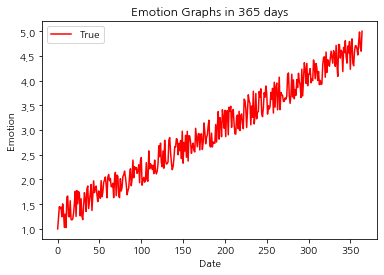

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.title("Emotion Graphs in 365 days")
plt.xlabel("Date")
plt.ylabel("Emotion")
plot_x = np.arange(365)
plot_y = emoData_365
plt.plot(plot_x, plot_y, color="red", label="True")
plt.legend(loc='best')
plt.show()

In [6]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [7]:
train = emoData_365[:train_marker]
val = emoData_365[train_marker:val_marker]
test = emoData_365[val_marker:]

x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, 
              callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

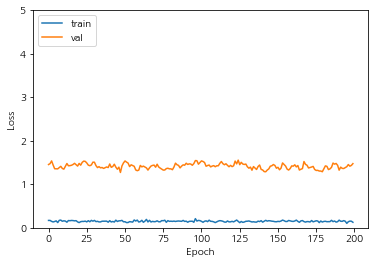

In [22]:
plt.clf()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 5.0)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.3818646909138344
Validataion Score:  1.475314862800367
Test Score:  2.570303187225804


In [26]:
look_ahead = 30
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])

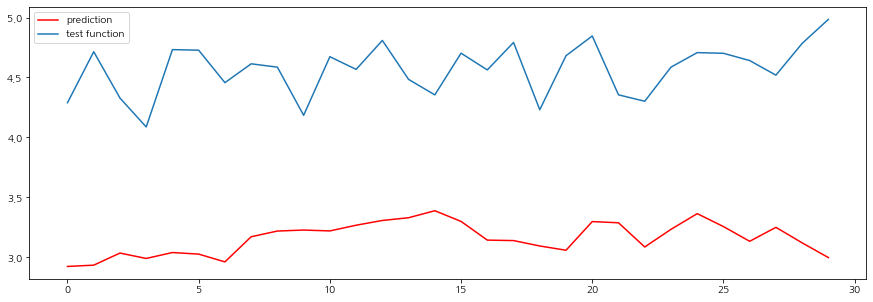

In [28]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()